## Introduction

### Background data

Cardiovascular diseases (CVDs) are the number 1 cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worlwide.
Heart failure is a common event caused by CVDs.

Most cardiovascular diseases can be prevented by addressing behavioural risk factors such as tobacco use, unhealthy diet and obesity, physical inactivity and harmful use of alcohol using population-wide strategies.

People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk factors such as hypertension, diabetes, hyperlipidaemia or already established disease) need early detection and management wherein a machine learning model can be of great help.

### Project description (overview)

The input to our predictor is is a medical dataset which contains 12 features that can be used to predict mortality by heart failure.
1. Data exploration
    - Principle Components Analysis (PCA) to reduce the dimension of features to have a view of the input data distribution
    - Build a preliminary linear SVM model to incorporate all the features to see the model performance.
2. Feature selection part.
    - Chi-square test to check the correlation between each categorical feature and the target death event.
    - Heat map to return the features with high correlation coefficient with death events.
    - Visualized the each feature's contribution significance in the SVM model
    - Compared the returned features and determined the final selected features
3. Model comparison and hyperparameter tuning
    - compare the performance in difference preprocessing methods MinMaxScalar, StandardScalar, RobustScalar
    - compare the performance in k-fold cross validation and leave-one-out methods
    - compare the kernel selected in Support Vector Machine (linear or rbf)
    - grid search to find the best performance model
4. Selected model performance
    - calculated the precision, recall, accuracy and f1-score
    - plot the ROC and PR-curve
    - plot the learning curve



---




## Related work

### Explorative data analysis (EDA) approach

1. [heart-fail-analysis-and-quick-prediction](https://www.kaggle.com/nayansakhiya/heart-fail-analysis-and-quick-prediction)

**Strength**: Detailed explorative and associative data analysis with great data visualization: each factor is visualized by different types of figures <br>
**Weakness**: Prediction model are quite rudimentary, the author did not select the features and tune the models' hyperparameters.<br>
**Similarity**: I learned and applied the plotly.express API to create fancy and concise figures for easy comparison; I furthered his rudimentary model by optimization

### Predictive data analysis (PDA) approach

1. [heart-failure-model-prediction-comparisons-95](https://www.kaggle.com/rude009/heart-failure-model-prediction-comparisons-95)

**Strength**: The author compares six prediction models with feature selection. The Extra Gradient Booster Classifier could achieve the accuracy up to 95.0% <br>
**Weakness**: The author consider the "time" column as the useful features. <br>
**Similarity**: I don't think "time" colume should be included since "time" column stands for Follow-up period (days), which means itself could not contribute the diseases itself. Therefore, I consider this feature as uselessness in our prediction model

2. [heart-failure-prediction-auc-0-98](https://www.kaggle.com/ksvmuralidhar/heart-failure-prediction-auc-0-98)

**Strength**: The author uses a new method: Chi-square test to find the correlation between single categorical feature with target death_event <br>
**Weakness**: The visualization part does not as fancy as previous work <br>
**Similarity**: I learned and used the Chi-square test to conduct the correlation test between single categorical data with the categorical death_event; but i didn't agree the author's method in using box plot comparison between numerical data with categorical data, I used heat map instead.

---

## Problem formulation

### Return the head of dataset (a overview of inside components)

In [1]:
import pandas as pd
# df = pd.read_csv("/home/yuxuan/kaggle/heart_failure_clinical_records_dataset.csv")
df = pd.read_csv("/Users/yuxuan/Desktop/kaggle/heart_failure_clinical_records_dataset.csv")
# df = pd.read_csv("../input/heart-failure-clinical-data/heart_failure_clinical_records_dataset.csv")
heart_data = df.copy()
heart_data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


### Print the size of the dataset

In [2]:
print(heart_data.shape)

(299, 13)


### Check the ratio of the NaNs for each column

In [3]:
for col in heart_data.columns:
    print(col, str(round(100* heart_data[col].isnull().sum() / len(heart_data), 2)) + '%')

age 0.0%
anaemia 0.0%
creatinine_phosphokinase 0.0%
diabetes 0.0%
ejection_fraction 0.0%
high_blood_pressure 0.0%
platelets 0.0%
serum_creatinine 0.0%
serum_sodium 0.0%
sex 0.0%
smoking 0.0%
time 0.0%
DEATH_EVENT 0.0%


---
### Dataset description
There are 13 dimensions and 299 samples. All the columns are devoid of NaNs. We need make some rules before the data processing。

Target features (binary classification): DEATH_EVENT

**Categorical data**
- Sex - Gender of patient Male = 1, Female =0
- Diabetes - 0 = No, 1 = Yes
- Anaemia - 0 = No, 1 = Yes
- High_blood_pressure - 0 = No, 1 = Yes
- Smoking - 0 = No, 1 = Yes
- DEATH_EVENT - 0 = No, 1 = Yes

**Numerical data**
- Age - Age of patient
- creatinine_phosphokinase - Level of the CPK enzyme in the blood (mcg/L)
- ejection_fraction - Percentage of blood leaving the heart at each contraction (percentage)
- platelets - Platelets in the blood (kiloplatelets/mL)
- serum_creatinine - Level of serum creatinine in the blood (mg/dL)
- serum_sodium - Level of serum sodium in the blood (mEq/L)
- time - Follow-up period (days)

### Citation or Reference

Dataset from Davide Chicco, Giuseppe Jurman: Machine learning can predict survival of patients with heart failure from serum creatinine and ejection fraction alone. BMC Medical Informatics and Decision Making 20, 16 (2020)

The dataset downloaded from Kaggle https://www.kaggle.com/andrewmvd/heart-failure-clinical-data


---
### Principle components analysis

Reduce the dimensions and return the sample distribution

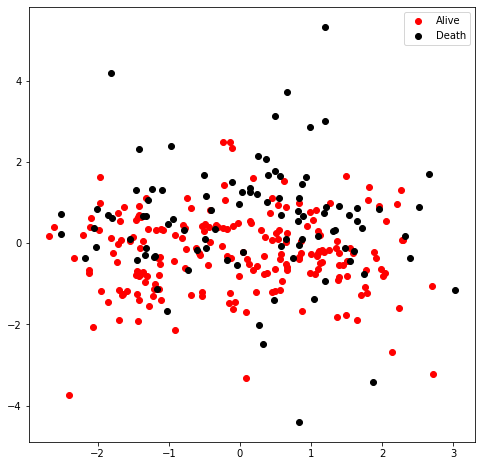

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
X = heart_data.iloc[:,0:11]
X = StandardScaler().fit_transform(X)
y = heart_data['DEATH_EVENT']
pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)

plt.figure(figsize=(8,8))
plt.scatter(X_pca[y==0,0],X_pca[y==0,1],label="Alive",c="red")
plt.scatter(X_pca[y==1,0],X_pca[y==1,1],label="Death",c="black")
plt.legend(["Alive","Death"])


I would like to have a view of the sample distribution in the dataset. Therefore, I used the principle component analysis (PCA) to reduce the dimension of features into 2D for visualization. The figure suggested that the data are densed and not easy to seperate (either linear or non-linear model), indicating the existence of insignificant feature which could negatively influence the future prediction accuracy.

---
### Correlation analysis
I would like to find the correlation between each feature, especially with the target variable: DEATH_EVENT.
In this case, I excluded the column "time" since the time tracked could not contribute to the heart failure itself.

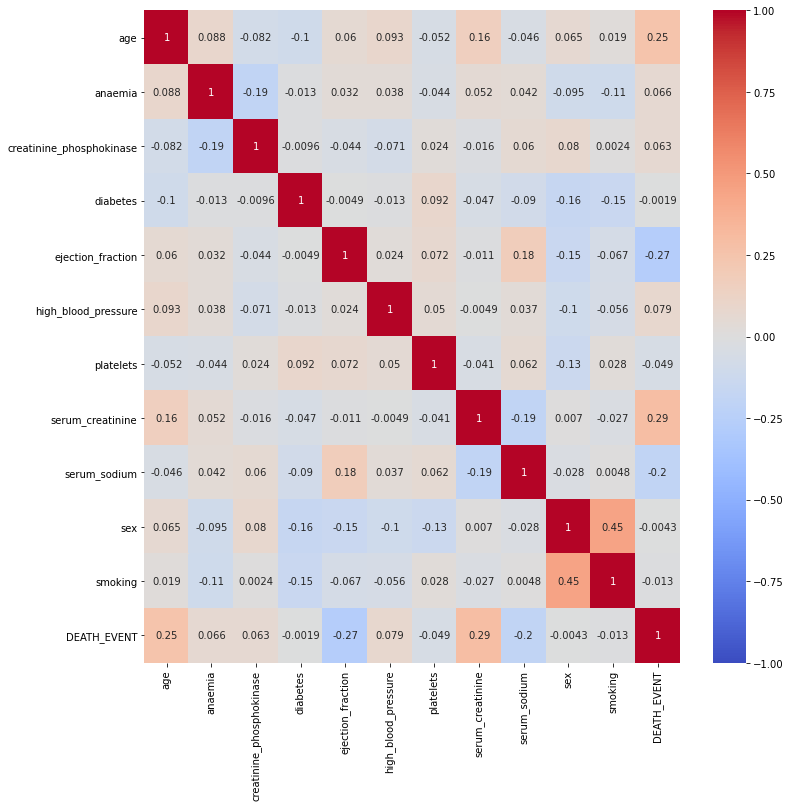

In [5]:
import seaborn as sn
heart_data = heart_data.drop(['time'],axis=1)
plt.figure(figsize=(12,12))
sn.heatmap(heart_data.corr(),vmin=-1,cmap='coolwarm',annot=True)

### Data partition

- As I mentioned before, I will not take the feature "time" into consideration. Therefore, 11 features are included in the final model prediction.
- I split the dataset into two categories. 80% for raining data and 20% for testing data.
- I used the StandardScalar normalization method to preprocess the data

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = heart_data.iloc[:,0:11]
X = StandardScaler().fit_transform(X)
y = heart_data['DEATH_EVENT']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=2)
print("The number of training sample is {}".format(X_train.shape[0]))
print("The number of testing sample is {}".format(X_test.shape[0]))

The number of training sample is 239
The number of testing sample is 60


### Feature selection (feature engineering)

**Method 1: Chi-square test**
- Based on previous research, I could conclude that DEATH_EVENT is our target. Since I have six categorical data I would like to figure out whether these single categorical valuable has significant correlation with the DEATH_EVENT.<br>
- Crosstables/contingency tables are one of the best ways to see how categorical variables are distributed among each other.
- The following test suggests that we failed to reject the $H_0$ problem, indicating that there is no direct relationship between the DEATH_EVENT

In [7]:
import pandas as pd
from scipy.stats import chi2_contingency
import numpy as np
heart_data = df.copy()
cat_features = ["anaemia","diabetes","high_blood_pressure","sex","smoking","DEATH_EVENT"]
num_features = pd.Series(heart_data.columns)
num_features = num_features[~num_features.isin(cat_features)]
num_features

for i in cat_features:
    ct = pd.crosstab(columns=heart_data[i],index=heart_data["DEATH_EVENT"])
    stat, p, dof, expected = chi2_contingency(ct)
    print('\n')
    print('-'*len('CROSSTAB BETWEEN {} & DEATH_EVENT'.format(i.upper())))
    print("CROSSTAB BETWEEN {} & DEATH_EVENT".format(i.upper()))
    print('-'*len('CROSSTAB BETWEEN {} & DEATH_EVENT'.format(i.upper())))
    print(ct)
    print('\n')
    print("H0: THERE IS NO RELATIONSHIP BETWEEN DEATH_EVENT & {} \nH1: THERE IS RELATIONSHIP BETWEEN DEATH_EVENT & {}".format(i.upper(),i.upper()))
    print("\nP-VALUE: {}".format(np.round(p,2)))
    print("REJECT H0" if p<0.05 else "FAILED TO REJECT H0")



--------------------------------------
CROSSTAB BETWEEN ANAEMIA & DEATH_EVENT
--------------------------------------
anaemia        0   1
DEATH_EVENT         
0            120  83
1             50  46


H0: THERE IS NO RELATIONSHIP BETWEEN DEATH_EVENT & ANAEMIA 
H1: THERE IS RELATIONSHIP BETWEEN DEATH_EVENT & ANAEMIA

P-VALUE: 0.31
FAILED TO REJECT H0


---------------------------------------
CROSSTAB BETWEEN DIABETES & DEATH_EVENT
---------------------------------------
diabetes       0   1
DEATH_EVENT         
0            118  85
1             56  40


H0: THERE IS NO RELATIONSHIP BETWEEN DEATH_EVENT & DIABETES 
H1: THERE IS RELATIONSHIP BETWEEN DEATH_EVENT & DIABETES

P-VALUE: 0.93
FAILED TO REJECT H0


--------------------------------------------------
CROSSTAB BETWEEN HIGH_BLOOD_PRESSURE & DEATH_EVENT
--------------------------------------------------
high_blood_pressure    0   1
DEATH_EVENT                 
0                    137  66
1                     57  39


H0: THERE 

**Method 2: correlation analysis**
- Use correlation coefficient > 0.1 with death event
- This method is applicable for both categorical data and numerical data

In [8]:
feature_corr = heart_data.corr()
feature_corr[abs(feature_corr['DEATH_EVENT']) > 0.1]['DEATH_EVENT']


age                  0.253729
ejection_fraction   -0.268603
serum_creatinine     0.294278
serum_sodium        -0.195204
time                -0.526964
DEATH_EVENT          1.000000
Name: DEATH_EVENT, dtype: float64

**Method 3: Visualized plots of feature importance in linear SVM**

In [9]:
import numpy as np
def feature_plot(classifier, feature_names, top_features=5):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    middle_coefficient = np.argsort(coef)[top_features]
    top_coefficients = np.hstack([top_negative_coefficients, middle_coefficient, top_positive_coefficients])
    plt.figure(figsize=(18, 7))
    colors = ['green' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features+1), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(2 * top_features+1), feature_names[top_coefficients], rotation=45, ha='right')

    plt.show()


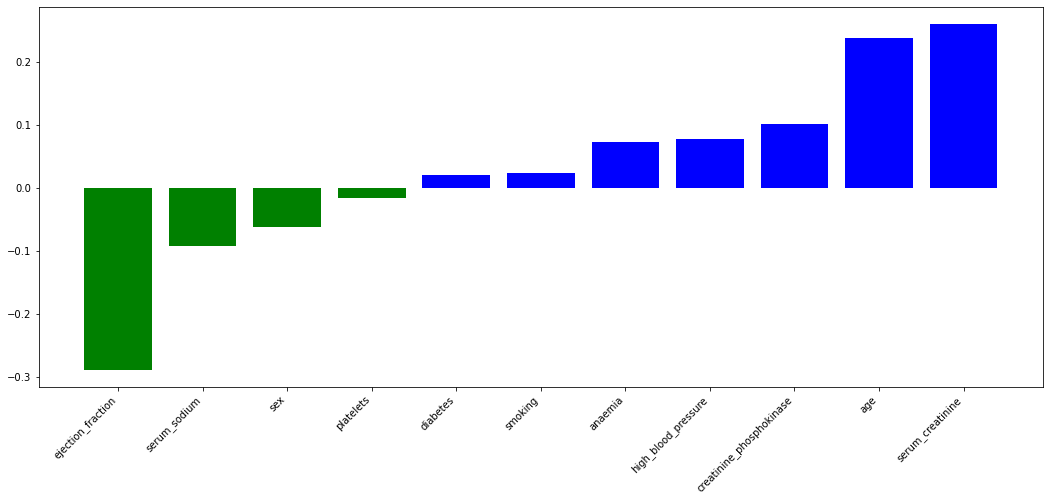

In [10]:
from sklearn.svm import LinearSVC
heart_data = df.copy()
X = heart_data.iloc[:, 0:11]
X = StandardScaler().fit_transform(X)
y = heart_data['DEATH_EVENT']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=1)

# print(heart_data.drop(['DEATH_EVENT', 'time'], axis=1).columns.values)

trainedsvm = LinearSVC().fit(X, y)
feature_plot(trainedsvm, heart_data.drop(['DEATH_EVENT', 'time'], axis=1).columns.values)


- The ahead plot illustrates the importance of feature in SVM model. y axis could be considered as weights and the absolute value of weights could suggest the contribution to the final results.
- The correlation analysis between factors and death event returned the coefficient > 0.1 features
- Both analysis returned three same features: serum_creatinine, age, ejection_fraction
- we need to evaluate and compare the performance in serum_sodium and creatinine_phosphokinase



In [11]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
heart_data = df.copy()
X = heart_data.iloc[:, 0:11]
y = heart_data['DEATH_EVENT']
options = ['serum_sodium','creatinine_phosphokinase']

for i in options:
    selected_feature = ['serum_creatinine','age', 'ejection_fraction']
    selected_feature.append(i)
    X_processed = X[selected_feature]
    X_processed = StandardScaler().fit_transform(X_processed)
    X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, shuffle=True, random_state=1)
    sv_clf = SVC(kernel="linear",random_state=1)
    sv_clf.fit(X_train, y_train)
    sv_clf_pred = sv_clf.predict(X_test)
    sv_clf_acc = accuracy_score(y_test,sv_clf_pred)
    sc_clf_acc_format = round(sv_clf_acc*100,2)
#     accuracy_list.append(round(sv_clf_acc,2))
    print("Accuracy of linear SVM model with feature {} is : {}%".format(i, sc_clf_acc_format))

Accuracy of linear SVM model with feature serum_sodium is : 81.67%
Accuracy of linear SVM model with feature creatinine_phosphokinase is : 83.33%


Therefore, four features including serum_creatinine, age, ejection_fraction, creatinine_phosphokinase

---
### Visualized the learning curve after feature selection

In [12]:
from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt



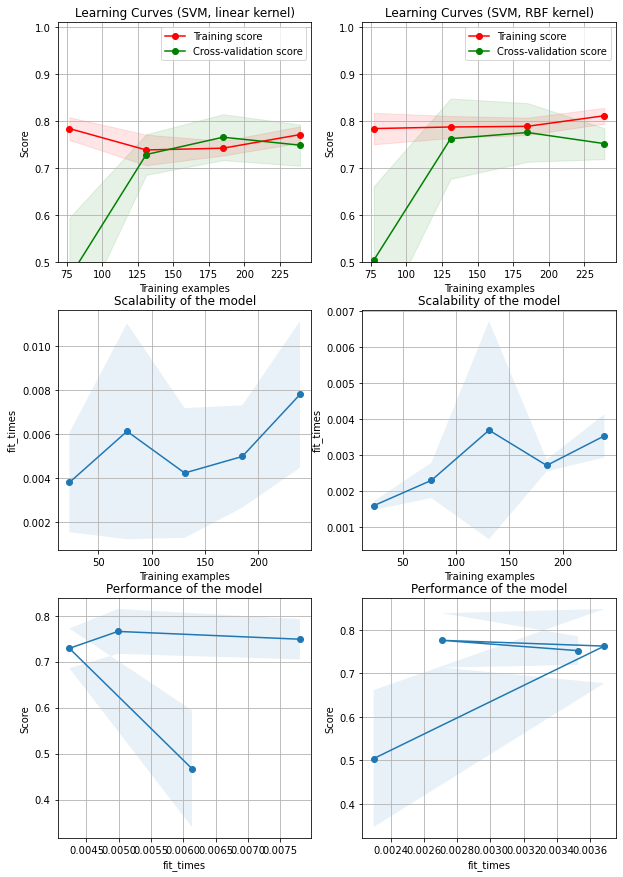

In [13]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

heart_data = df.copy()

X = heart_data.iloc[:, 0:11]
y = heart_data['DEATH_EVENT']

selected_feature = ['serum_creatinine','age', 'ejection_fraction','creatinine_phosphokinase']
X_processed = X[selected_feature]
X_processed = StandardScaler().fit_transform(X_processed)


title = "Learning Curves (SVM, linear kernel)"
# cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

estimator = SVC(kernel="linear",random_state=1)
plot_learning_curve(estimator, title, X_processed, y, axes=axes[:, 0], ylim=(0.5, 1.01),
                     n_jobs=10)


title = r"Learning Curves (SVM, RBF kernel)"

# cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(kernel="rbf",random_state=1)
plot_learning_curve(estimator, title, X_processed, y, axes=axes[:, 1], ylim=(0.5, 1.01),
                     n_jobs=10)

plt.show()



- First column is the combination of learning curves, model scability, model performance in a SVM model with linear kernel. First row is the learning curve of linear SVM model: the training score is very high at the beginning and decreases and the cross-validation score is very low at the beginning and increases. The training score and the cross-validation score intertwines at about 220 training samples, and their difference after that are not significant

- Second column is the combination of learning curves, model scability, model performance in a SVM model with linear kernel. The learning curve plots indicate that accuracy for both training score and cross validation score tend to be stable after 130 samples, which is similar in linear SVM model. The fit time for RBF kernel SVM is higher than linear kernel because of the complexity in calculation

- RBF kernel has a relative higher performance, but the difference is not significant

- The figure above doesn't indicate either overfitting or underfitting problems



---
### Explorative data analysis of the four selected features:
- 'serum_creatinine'
- 'age'
- 'ejection_fraction'
- 'creatinine_phosphokinase'

#### Specify the figure size

In [14]:
HEIGHT = 500
WIDTH = 700
NBINS = 50
SCATTER_SIZE=700

In [15]:
## Define the histogram
import plotly.express as px
def plot_histogram(dataframe, column, color, bins, marginal,title, width=WIDTH, height=HEIGHT):
    figure = px.histogram(
        dataframe,
        column,
        color=color,
        nbins=bins,
        marginal= marginal,
        title=title,
        width=width,
        height=height
    )
    figure.show()


In [16]:
plot_histogram(heart_data, 'serum_creatinine', 'DEATH_EVENT', NBINS, "violin",'Figure 1: Distribution of serum creatinine VS death event')

In [17]:
plot_histogram(heart_data, 'ejection_fraction', 'DEATH_EVENT', NBINS, "violin",'Figure 2: Distribution of ejection fraction VS death event')

In [18]:
plot_histogram(heart_data, 'creatinine_phosphokinase', 'DEATH_EVENT', NBINS, "violin",'Figure 3: Distribution of creatinine_phosphokinase VS death event')

In [19]:
import plotly.graph_objs as go
heart_data = df.copy()
male = heart_data[heart_data["sex"]==1]
female = heart_data[heart_data["sex"]==0]
male_survival= male[male["DEATH_EVENT"]==0]
female_survival= female[female["DEATH_EVENT"]==0]
## assign the labels
labels = ['Male - Survived','Male - Not Survived', "Female -  Survived", "Female - Not Survived"]
## value is set according to the labels
values = [len(male[heart_data["DEATH_EVENT"]==0]),len(male[heart_data["DEATH_EVENT"]==1]),
         len(female[heart_data["DEATH_EVENT"]==0]),len(female[heart_data["DEATH_EVENT"]==1])]
fig = go.Figure(data=[go.Pie(labels=labels,values=values,hole=.3)])
fig.update_layout(
    title_text = "Figure 4: Analysis on Survival - Gender factor"
)
fig.show()

In [20]:
## Define the violin plot function method
def violin_boxplot(dataframe, x, y,color,points,hover_data, box, width=WIDTH, height=HEIGHT):
    figure = px.violin(
        dataframe,
        x=x,
        y=y,
        color = color,
        box = box,
        hover_data=hover_data,
        points=points,
        width=width,
        height=height
    )
    figure.update_layout(title_text="Figure 5: Analysis of both gender and age factors in survival rates")
    figure.show()

In [21]:
violin_boxplot(heart_data,x = "sex",y="age",color="DEATH_EVENT",points="all",box=True,hover_data=heart_data.columns)

Figure 1 - Figure 5 is the visualization of each feature, there is no clear patterns or strong association between the death_event. Therefore, we need to further our research by conducting the model prediction process.


## Methods

### Python library

# Description: how you learned the predictor

In [22]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.svm import LinearSVC

### PCA to visualize the sample distribution

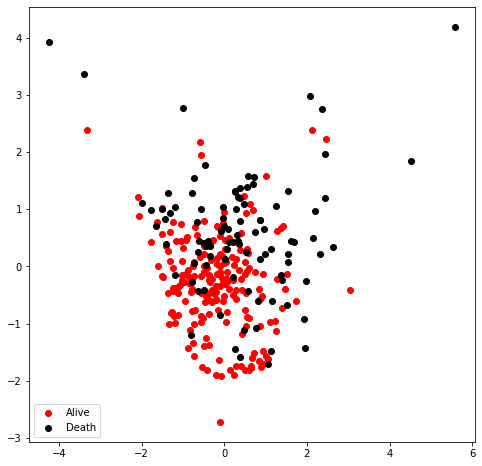

In [23]:
pca = PCA(n_components=2)
pca.fit(X_processed)
X_pca = pca.transform(X_processed)

plt.figure(figsize=(8,8))
plt.scatter(X_pca[y==0,0],X_pca[y==0,1],label="Alive",c="red")
plt.scatter(X_pca[y==1,0],X_pca[y==1,1],label="Death",c="black")
plt.legend(["Alive","Death"])

In this case, the data distribution after feature selection are scattered, which could be beneficial for separation. Still, we could not determine whether linear kernel or RBF kernel is suitable for classification. I then would compare the performance between these two methods.


### Machine learning algorithms with description

#### SVM with linear kernel

$$ K(x,y) = X^Ty=x\cdot y$$

Loss function: hinge loss / squared hinge loss

$$ Agreement: z = y_i(w \cdot x_i + \alpha) $$

Hinge loss

$$
L_h(z)= \begin{cases}
0 & \text{if z$\geq$1}\\
1-z & \text{z<1}
\end{cases}
$$

Squared hinge loss

$$
L_{hsqr}(z)= \begin{cases}
0 & \text{if z$\geq$1}\\
(1-z)^2 & \text{z<1}
\end{cases}
$$


Optimization objective formula for hinge loss:

$$
J(w,\alpha) = \frac{1}{n}\sum_{i=1}^nL_h(y_i(w\cdot x_i + \alpha))+\frac{\lambda}{2}(||w||)^2
$$

Description:
- Linear Kernel is used when the data is linearly separable dataset.
- One of the goal is to minimize the previous objective formula for the hinge loss. $\lambda$ in this case stands for the regularization hyperparameter.
- The strength of the regularization is inversely proportional to $\lambda$, it has to be strictly positive. The smaller regularization parameter means less tolerant to misclassification.
- Require grid serach to return the suitable hyperparameter


#### SVM with RBF kernel

$$ K(x,y) = e^{-\gamma||x-y||^2}, \gamma >0 $$

Loss function: hinge loss / squared hinge loss

$$ Agreement: z = y_i(w \cdot \phi(x_i) + \alpha) $$

Hinge loss

$$
L_h(z)= \begin{cases}
0 & \text{if z$\geq$1}\\
1-z & \text{z<1}
\end{cases}
$$

Squared hinge loss

$$
L_{hsqr}(z)= \begin{cases}
0 & \text{if z$\geq$1}\\
(1-z)^2 & \text{z<1}
\end{cases}
$$


Optimization objective formula for hinge loss:

$$
J(w,\alpha) = \frac{1}{n}\sum_{i=1}^nL_h(y_i(w\cdot \phi(x_i) + \alpha))+\frac{\lambda}{2}(||w||)^2
$$

Description:

- SVM with RBF kernel was utilized to solve the linearly inseparable probelms
- kernel trick was used in RBF kernel SVM to increase the computational efficiency
- $\gamma$ parameter how far the influence of a single training example reaches
- C parameter trades off correct classification of training examples against maximization of the decision function’s margin

#### Evaluation method

Mean squared error (MSE)

$$
MSE = \frac{1}{n}\sum_{i=1}^n(Y_i- \hat{Y_i})^2

$$

where $Y_i$ is the label and $\hat{Y_i}$ is the predicted label by model


In [24]:
heart_data = df.copy()

X = heart_data.iloc[:, 0:11]
y = heart_data['DEATH_EVENT']

selected_feature = ['serum_creatinine','age', 'ejection_fraction','creatinine_phosphokinase']
X_processed = X[selected_feature]
X_processed = StandardScaler().fit_transform(X_processed)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, shuffle=True, random_state=1)

## linear svm
# sv_clf = LinearSVC(loss='hinge',random_state=1, C=1.0, penalty = 'l2')
sv_clf = SVC(kernel="linear",random_state=1)
sv_clf.fit(X_train, y_train)
sv_clf_pred = sv_clf.predict(X_test)
sv_clf_acc = accuracy_score(y_test,sv_clf_pred)
sv_clf_mse = mean_squared_error(y_test,sv_clf_pred)
print("Accuracy of linear SVM model is :","{:.2f}%".format(100*sv_clf_acc))
print("Mean squared error of linear SVM model is :","{:.2f}".format(sv_clf_mse))

## RBF kernel SVM
sv_clf = SVC(kernel="rbf",random_state=1, C=1.0, gamma=0.1)
sv_clf.fit(X_train, y_train)
sv_clf_pred = sv_clf.predict(X_test)
sv_clf_acc = accuracy_score(y_test,sv_clf_pred)
sv_clf_mse = mean_squared_error(y_test,sv_clf_pred)
print("Accuracy of RBF SVM model is :","{:.2f}%".format(100*sv_clf_acc))
print("Mean squared error of linear SVM model is :","{:.2f}".format(sv_clf_mse))


Accuracy of linear SVM model is : 83.33%
Mean squared error of linear SVM model is : 0.17
Accuracy of RBF SVM model is : 86.67%
Mean squared error of linear SVM model is : 0.13


## Experiments and results


### Compare the efficacy of different preprocessing methods
- MinMaxScalar
- StandardScalar
- RobustScalar

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

heart_data = df.copy()

X = heart_data.iloc[:, 0:11]
y = heart_data['DEATH_EVENT']

selected_feature = ['serum_creatinine','age', 'ejection_fraction','creatinine_phosphokinase']
X_processed = X[selected_feature]
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, shuffle=True, random_state=1)

# MinMaxScalar
pipe1 = Pipeline([("scalar",MinMaxScaler()),("svm",SVC(random_state=1))])
pipe1.fit(X_train,y_train)
print("Test score for MinMaxScalar RBF kernel: {:.3f}".format(pipe1.score(X_test,y_test)))

pipe1_linear = Pipeline([("scalar",MinMaxScaler()),("svm",SVC(kernel="linear",random_state=1))])
pipe1_linear.fit(X_train,y_train)
print("Test score for MinMaxScalar linear kernel: {:.3f}\n".format(pipe1_linear.score(X_test,y_test)))


# StandardScalar

pipe2 = Pipeline([("scalar",StandardScaler()),("svm",SVC(random_state=1))])
pipe2.fit(X_train,y_train)
print("Test score for StandardScalar in RBF kernel: {:.3f}".format(pipe2.score(X_test,y_test)))

pipe2_linear = Pipeline([("scalar",StandardScaler()),("svm",SVC(kernel="linear" ,random_state=1))])
pipe2_linear.fit(X_train,y_train)
print("Test score for StandardScalar in linear kernel: {:.3f}\n".format(pipe2_linear.score(X_test,y_test)))

# RobustScalar

pipe3 = Pipeline([("scalar",RobustScaler()),("svm",SVC(random_state=1))])
pipe3.fit(X_train,y_train)
print("Test score for RobustScalar in RBF kernel: {:.3f}".format(pipe3.score(X_test,y_test)))

pipe3_linear = Pipeline([("scalar",RobustScaler()),("svm",SVC(kernel = "linear",random_state=1))])
pipe3_linear.fit(X_train,y_train)
print("Test score for RobustScalar in linear kernel: {:.3f}".format(pipe3_linear.score(X_test,y_test)))

Test score for MinMaxScalar RBF kernel: 0.850
Test score for MinMaxScalar linear kernel: 0.767

Test score for StandardScalar in RBF kernel: 0.850
Test score for StandardScalar in linear kernel: 0.833

Test score for RobustScalar in RBF kernel: 0.800
Test score for RobustScalar in linear kernel: 0.817


- There is no significant difference between different preprocessing method in RBF kernels, especially in MinMaxScalar and StandardScalar.
- Overall RBF kernel outperforms than linear kernel.
- In this case, I would insist on using StandardScalar in following procedure.
<br>
<br>
<br>



### Compare the model performance by ten-fold cross validation and leave-one-out method in model evaluation
<br>

Owing to the fact that the dataset I used is a small one, only containing 299 samples in total. In order to minimize the bias or error leading by accident, I used ten-fold cross validation and leave-one-out method to return a more general evaluation (calculating the mean value)

#### Ten-fold cross validation of SVM

In [26]:
heart_data = df.copy()
X = heart_data.iloc[:, 0:11]
y = heart_data['DEATH_EVENT']

selected_feature = ['serum_creatinine','age', 'ejection_fraction','creatinine_phosphokinase']
X_processed = X[selected_feature]
X_processed = StandardScaler().fit_transform(X_processed)

from sklearn.model_selection import cross_val_score
sv_clf = SVC(kernel= 'linear',random_state=1)
sv_clf_rbf = SVC(kernel='rbf',random_state=1)
scores = cross_val_score(sv_clf, X_processed,y,cv=10)
scores_rbf = cross_val_score(sv_clf_rbf, X_processed,y,cv=10)

print("Ten-fold cross validation scores of linear SVM:{:.3f} ".format(np.mean(scores)))
print("Ten-fold cross validation scores of RBF kernel SVM:{:.3f}".format(np.mean(scores_rbf)))


Ten-fold cross validation scores of linear SVM:0.756 
Ten-fold cross validation scores of RBF kernel SVM:0.763


#### Leave-on-out method of SVM

In [27]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
scores_loo = cross_val_score(sv_clf,X_processed,y,cv=loo)
scores_loo_rbf = cross_val_score(sv_clf_rbf,X_processed,y,cv=loo)
print("Number of CV iterations: {}".format(len(scores_loo)))
print("Leave one out method mean scores for linear SVM:{:.3f}".format(scores_loo.mean()))
print("Leave one out method mean scores for RBF SVM:{:.3f}".format(scores_loo_rbf.mean()))

Number of CV iterations: 299
Leave one out method mean scores for linear SVM:0.763
Leave one out method mean scores for RBF SVM:0.756


#### Comparison of the two methods

In [28]:
print("Ten-fold cross validation scores of linear SVM:{:.3f} ".format(np.mean(scores)))
print("Ten-fold cross validation scores of RBF kernel SVM:{:.3f}".format(np.mean(scores_rbf)))
print("Leave one out method mean scores for linear SVM:{:.3f}".format(scores_loo.mean()))
print("Leave one out method mean scores for RBF SVM:{:.3f}".format(scores_loo_rbf.mean()))

Ten-fold cross validation scores of linear SVM:0.756 
Ten-fold cross validation scores of RBF kernel SVM:0.763
Leave one out method mean scores for linear SVM:0.763
Leave one out method mean scores for RBF SVM:0.756


**Summary: **
The results of either ten-fold cross validation and leave-one-out method results are quite similar, based on the consideration of time elapse, I would use ten-fold cross-validation for the following analysis

### Hyperparameters tuning

- Grid search for SVM algorithm with ten-fold cross validation method

In [29]:
from sklearn.model_selection import GridSearchCV
param_grid = [{'kernel': ['rbf'],
               'C': [0.01,0.1,1,10,100],
               'gamma':[0.01,0.1,1,10,100]},
                {'kernel':['linear'],
               'C': [0.01,0.1,1,10,100]
                }]
# print(param_grid)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, shuffle=True, random_state=1)

grid_search = GridSearchCV(SVC(random_state=1),param_grid,cv =10, n_jobs=-1)
grid_search.fit(X_train,y_train)
print("Best cross validation accuracy: {:.2f}".format(grid_search.best_score_))
print("Test set score: {:.2f}".format(grid_search.score(X_test,y_test)))
print("Best parameters: {}".format(grid_search.best_params_))


Best cross validation accuracy: 0.75
Test set score: 0.87
Best parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}


In [30]:
results = pd.DataFrame(grid_search.cv_results_)
results_rbf = results.iloc[0:25,:]
results_linear = results.iloc[25:,:]
# display(results_linear.T.head())
# display(results_rbf.T.head())
# display(results.T.head())
# display(results.T)


Text(0.5, 87.0, 'gamma')

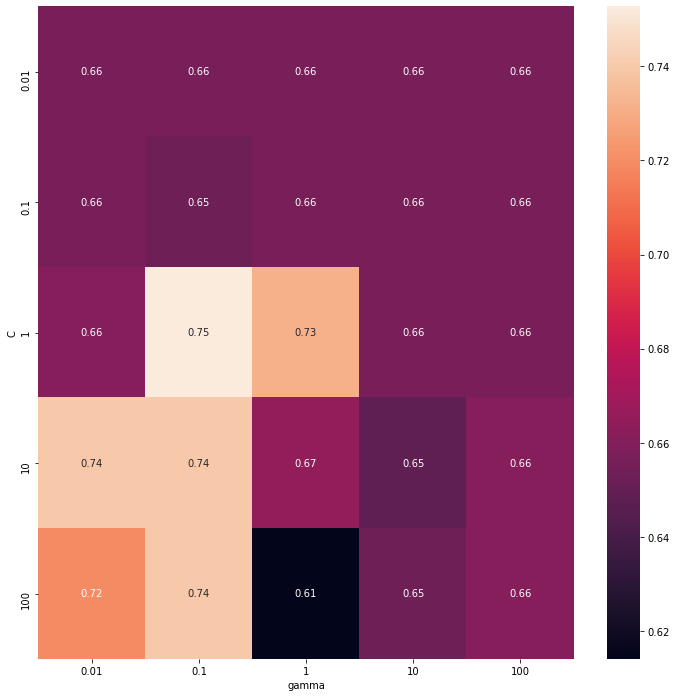

In [31]:
plt.figure(figsize=(12,12))
scores = np.array(results_rbf.mean_test_score).reshape(5,5)

heatmap = sn.heatmap(data=scores,xticklabels=param_grid[0]['gamma'],
           yticklabels=param_grid[0]['C'],
           annot=True)
plt.ylabel('C')
plt.xlabel("gamma")

In [32]:
sv_clf_rbf = SVC(kernel='rbf',random_state=1,C=1, gamma = 0.1)
scores_loo_rbf = cross_val_score(sv_clf_rbf,X_processed,y,cv=10)
# print("Number of CV iterations: {}".format(len(scores_loo)))
print("10-fold cross validation mean method scores for RBF SVM:{:.3f}".format(scores_loo_rbf.mean()))

10-fold cross validation mean method scores for RBF SVM:0.763


As can be seen from the grid search, the SVM with RBF kernel and hyperparameter C: 1, gamma 0.1 could achieve the highest performance

In [33]:
linear_score = np.array(results_linear.mean_test_score)
display(results_linear.T.head())
print(max(linear_score))

,25,26,27,28,29
mean_fit_time,0.002583,0.00185556,0.00276024,0.00816383,0.0532697
std_fit_time,0.000573951,0.000226007,0.000636118,0.00444976,0.0121676
mean_score_time,0.000744629,0.000639081,0.000728345,0.000728059,0.000755
std_score_time,0.00016837,8.2315e-05,0.000186786,0.000162194,9.91922e-05
param_C,0.01,0.1,1,10,100


0.7358695652173913


In the meantime, the best performance in linear model is 0.73587, and the mean_test_score in c =1,10,100 is relative similar. The influence of hyperparameter C are not significant. Apart from that the SVC function only provide

In [34]:
### Hyperparameter tuning for linear SVM (penalty, loss, C)

In [35]:
parameters = {'penalty':['l1', 'l2'], 'loss':['hinge', 'squared_hinge'],'C':[1, 10,100]}
grid_search = GridSearchCV(LinearSVC(random_state=1),parameters,cv =10, n_jobs=-1)
grid_search.fit(X_train,y_train)
print("Best cross validation accuracy: {:.2f}".format(grid_search.best_score_))
print("Test set score: {:.2f}".format(grid_search.score(X_test,y_test)))
print("Best parameters: {}".format(grid_search.best_params_))

Best cross validation accuracy: 0.75
Test set score: 0.80
Best parameters: {'C': 10, 'loss': 'squared_hinge', 'penalty': 'l2'}


The test score of linear svm (test set score:0.80) still could not compete with the rbf kernel (test set score: 0.87), therefore, I would still insist on the SVM with RBF kernel and hyperparameter C: 1, gamma 0.1

In [36]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
heart_data = df.copy()

X = heart_data.iloc[:, 0:11]
y = heart_data['DEATH_EVENT']

selected_feature = ['serum_creatinine','age', 'ejection_fraction','creatinine_phosphokinase']
X_processed = X[selected_feature]
X_processed = StandardScaler().fit_transform(X_processed)
X_train, X_test, y_train, y_test = train_test_split(X_processed,y,test_size=0.2,random_state=2)
model = SVC(kernel='rbf',random_state=1,C=1, gamma = 0.1)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)


### Training and validation loss

In [37]:
print("Training loss is: {}".format(round(model.score(X_train,y_train),2)))
print("Testing loss is: {}".format(round(model.score(X_test,y_test),2)))

Training loss is: 0.78
Testing loss is: 0.83


In [38]:
train_mse = mean_squared_error(y_train,y_pred_train)
test_mse = mean_squared_error(y_test,y_pred)
print("The MSE value of training sample is: {}".format(round(train_mse,2)))
print("The MSE value of testing sample is: {}".format(round(test_mse,2)))

The MSE value of training sample is: 0.22
The MSE value of testing sample is: 0.17


The training loss in SVM with RBF kernel in hyperparameter C: 1, gamma 0.1 is 0.78, with testing loss equals 0.83
The MSE value for training and testing in SVM with RBF kernel is 0.22 and 0.17 accordingly


### Plot the confusion matrix plot

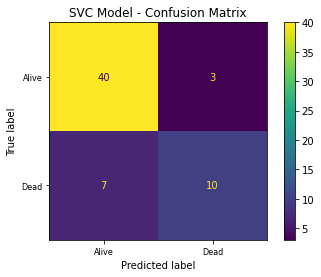

In [39]:
# confusion = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(model,X_test,y_test)
plt.title("SVC Model - Confusion Matrix")
plt.xticks(range(2), ["Alive", "Dead"], fontsize=8)
plt.yticks(range(2), ["Alive", "Dead"], fontsize=8)
plt.show()

### Evaluate the performance of the final selected model performance with respect to the chosen performance matrix
<br>

### Accuracy:
$$\frac{TP+TN}{TP+TN+FP+FN}$$
<br>
### Total:
$$Total = TP+TN+FP+FN$$
### Precision:
$$\frac{TP}{TP+FP}$$
### Recall:
$$\frac{TP}{TP+FN}$$

In [40]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred,target_names=["Heart Not Failed", "Heart Fail"]))

                  precision    recall  f1-score   support

Heart Not Failed       0.85      0.93      0.89        43
      Heart Fail       0.77      0.59      0.67        17

        accuracy                           0.83        60
       macro avg       0.81      0.76      0.78        60
    weighted avg       0.83      0.83      0.83        60



### ROC curve

AUC = Area under the curve

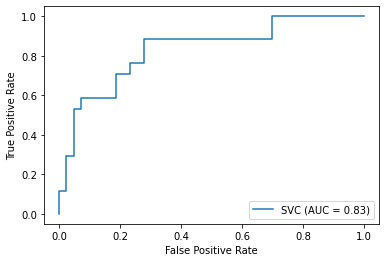

In [41]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve
plot_roc_curve(model,X_test,y_test)

### PR-curve

AP = Average Precision, summarizes such a plot as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight:

$$ AP =\sum_{N}(R_n-R_{n-1})P_n$$

where  and  are the precision and recall at the nth threshold. A pair  is referred to as an operating point.

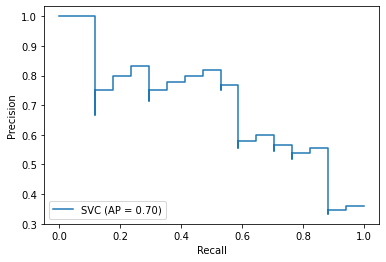

In [42]:
plot_precision_recall_curve(model,X_test,y_test)

### Summary of the results

- Grid search to find the best hyperparameters in optimization of the model
- ten-fold cross validation used to evaluate machine learning models on a limited data sample
- SVM with RBF kernel and hyperparameter C: 1, gamma 0.1 would be the best performed model
- precision, recall, f1-score, accuracy value were applied and summarized in the previous table
- train loss and validation loss were 0.78 and 0.83 accordingly
- MSE value of training sample and testing sample is 0.22 and 0.17 accordingly
- No overfitting or underfitting problem observed because regularization method, cross-validation method were used to mitigate the potential problems
- The overall model is robust and in good generalization ability
- ROC curve and PR curve were visualized to demonstrate the final results; AUC is 0.83 and AP is 0.7




## Conclusion and future work

In this project, I compared and devised a RBF SVM machine learning model for the prediction of heart failure. I firstly conducted a preliminary analysis of the whole dataset and utilized the PCA method to visualize the distribution condition of the samples. The initial analysis was not robust and precise, which required me to optimize the model. Then, I conducted feature selection to return the top 4 most correlated feature with the death event. Apart from that, I also compared the difference between normalization method as well as the validation methods. The final determined methods were to use four selected features ('serum_creatinine','age','ejection_fraction', 'creatinine_phosphokinase'), StandardScalar methods and ten-fold cross validation to conduct the prediction. In addition, I also conduct the explorative data analysis to have a view of the selected feature. Furthermore, the PCA condition after feature selection still could not determine whether the dataset is linearly seperable or not, I, therefore, used the grid serach to return the most suitable hyperparameters. The final results suggested that the SVM with RBF kernel in gamma equals 0.1 and penalty C equals 1 could achieve the best performance. After that, the model performance was evaluated from confusion matrix, accuracy, precision, recall, f1-score. Moreover, the ROC plot and PR-curve plot with AUC and AP accordingly were indicated. The final accuracy could achieve 0.83, which is satisfactory.

In the future, since this project only used SVM related algorithms, I would like to incorporate more complicate algorithms, for instance, XGboost. Furthermore, the model's interpretability are not great enough, and that would be my focus in the future.

## Bibliography

Heart Fail:Analysis and Quick-prediction | Kaggle. (n.d.). Retrieved January 8, 2021, from https://www.kaggle.com/nayansakhiya/heart-fail-analysis-and-quick-prediction

Heart Failure - Model Prediction Comparisons (95%) | Kaggle. (n.d.). Retrieved January 8, 2021, from https://www.kaggle.com/rude009/heart-failure-model-prediction-comparisons-95

Heart Failure Prediction (AUC: 0.98) | Kaggle. (n.d.). Retrieved January 8, 2021, from https://www.kaggle.com/ksvmuralidhar/heart-failure-prediction-auc-0-98

Pedregosa et al., Scikit-learn: Machine Learning in Python, JMLR 12, pp. 2825-2830, 2011.


## Other resources to download the code

Kaggle:
https://www.kaggle.com/yuxuanwu17/eda-of-heart-failure-and-optimization-of-svm

Github:
https://github.com/yuxuanwu17/kaggle/blob/main/Final_report.ipynb


